# Predicting class & finding most similar image from models

I have created a feature dictionary from the output of a ResNet34 model in `finding_similar_images.ipynb`.  Actually, I need to take notes on what I'm doing on this model so that I understand how this works.  
  


In [1]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
from lshash_2 import LSHash
#from lshash import LSHash
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
pd.set_option('display.max_columns', 500)

In [2]:
path = '../../repo/data/model_images/'

In [44]:
# get_Transforms is a fastai function
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)

In [48]:
data = (ImageList.from_folder(path+'pipelinetest/')
        .split_none()
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=1))

In [7]:
learn=cnn_learner(data, models.resnet34, metrics=error_rate);
learn.load('./stg2-rn34');

In [67]:
class SaveFeatures():
    """This is a hook (used for saving intermediate computations) used to extract before the last FC
    layer for use in similarity matching.
    Attributes:
        hook: the hook you want to grab data from
        features: extracted features
    Methods:
        hook_fn(module, input, output)
        remove()
    """
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))

    def remove(self):
        self.hook.remove()

In [60]:
learn.data = data

In [78]:
hmm = learn.get_preds(data.train_ds)[0]

In [81]:
type(learn.model[1][5])

torch.nn.modules.activation.ReLU

In [69]:
sf = SaveFeatures(learn.model[1][5])

In [79]:
query = hmm.sf.features[-1].flatten()

AttributeError: 'Tensor' object has no attribute 'sf'

## predicting the category

In [30]:
prediction = learn.predict(img)
prediction

NameError: name 'categories' is not defined

## finding the most similar images

In [33]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path+'feature_dict.p','rb'))
print(feature_dict['../../repo/data/model_images/test/693197469.jpg'])

[ 9.41564   0.        0.        0.       ...  8.928847  0.       14.353321  0.      ]


In [ ]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 6  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

In [16]:
lsh = pickle.load(open(path+'lsh.p','rb'))
print(lsh)

<function LSHash.cosine_dist at 0x1a2bbd3ea0>


In [ ]:
response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')

In [12]:
#def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

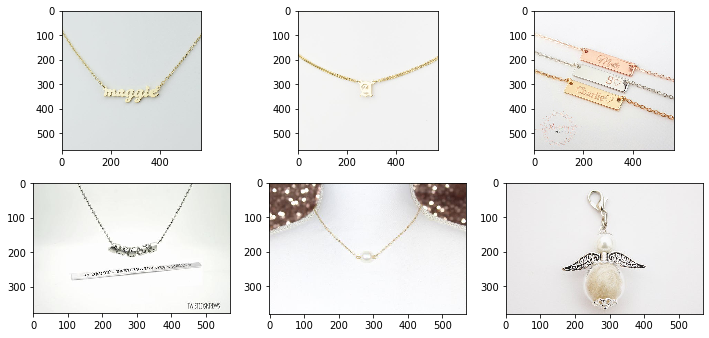

In [13]:
get_similar_item(0, feature_dict, lsh,5)